# DATA 88 Cumulative Project: *Running Various Classification Techniques on Murine Brain Cell Data & Determining their Accuracy* 
### By: Catey Vera, Sofia Kwee, Ayda Nayeb Nazar, and Trishala Jain

### *1. Introduction to the lab and data:*

In this notebook, we aim to use data from a 2019 Harvard study on murine brain cell types to classify a mouse as 'young' or 'old'.  The original data was sourced from NCBI's Gene Expression Omnibus dataset entitled "Single-cell transcriptomic profiling of the aging mouse brain," which can be found here: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE129788.
The classifiers we intend to simulate in this lab are as follows:

- Neural Networks

We begin by importing relevant modules:

In [12]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.style.use('fivethirtyeight')
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
plt.style.use('fivethirtyeight')

import keras
from sklearn.metrics import confusion_matrix
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder

We then load all the needed data:

In [13]:
sc_meta = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Project_data/OPC_meta.csv', index_col = 0)

In [14]:
sc_mat = pd.read_csv('https://raw.githubusercontent.com/ds-connectors/Data88-Genetics_and_Genomics/master/Project_data/OPC_mat.csv', index_col = 0)

### *2. Visualization via PCA and t-SNE:*

Before conducting our classification algorithms, it was important for us to get a rough sense of our data.  In order to accomplish this, we first used a technique called "Principal Component Analysis," which is a dimensionality reduction technique which finds the most prominent linearly uncorrelated variables.

We first apply the built-in scaler and then perform PCA on this matrix.

In [16]:
x = StandardScaler().fit_transform(np.log2(sc_mat.T+1))
pca = PCA(n_components = 100)
principalComponents = pca.fit_transform(x)

To see the results of PCA, we plot the projections and see if they separate by cell type. In this case, we know the true labels of cells from the experiment.

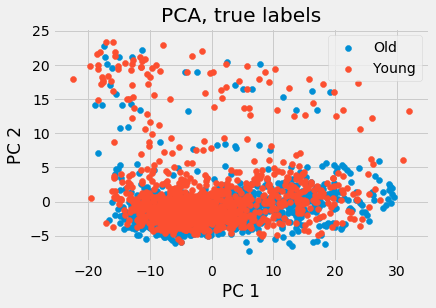

In [17]:
plt.scatter(principalComponents[sc_meta['animal_type'] == 'old',0], principalComponents[sc_meta['animal_type'] == 'old',1])
plt.scatter(principalComponents[sc_meta['animal_type'] == 'young',0], principalComponents[sc_meta['animal_type'] == 'young',1])
plt.legend(['Old','Young'])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA, true labels')
plt.show()

Next, we use t-SNE, a non-linear dimenstion reduction method which we apply after PCA, which is well-suited for the visualization of high-dimensional datasets.

In [18]:
tsne = TSNE(n_components = 2)
X_embedded = tsne.fit_transform(principalComponents)

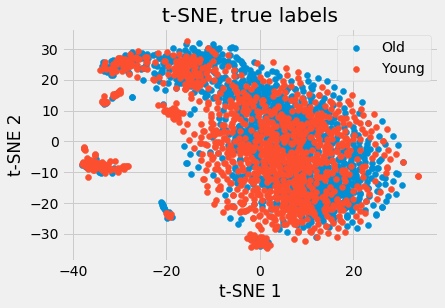

In [19]:
plt.scatter(X_embedded[sc_meta['animal_type'] == 'old',0], X_embedded[sc_meta['animal_type'] == 'old',1])
plt.scatter(X_embedded[sc_meta['animal_type'] == 'young',0], X_embedded[sc_meta['animal_type'] == 'young',1])
plt.legend(['Old','Young'])
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE, true labels')
plt.show()

### *3. Splitting into training and test data:*

We now extract the animal type labels and gene expression values for all the cells.  Note that the [:] prevents aliasing by generating a new copy, and that we must transpose the data in order to apply the classifier.

In [20]:
sc_labels = sc_meta.animal_type[:]   
sc_features = sc_mat.T                 

We may now split our data into training sets and test sets using the built in 'train_test_split' function.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(sc_features, sc_labels, test_size=0.3)

### *4. Neural Networks Classification Algorithm:*

The neural network takes in inputs called features, and in this case we take in gene expressions as the features which go into the input layer. Each neuron sends its value through weights that are connected to the next neuron in the next hidden layer, as it goes through the weight it accumulates the information it needs until it reaches the final neuron. Then, we force the last two neurons to form a probability distribution in order to perform our classification using softmax. Once this is computed, we find a way to measure the network's performance by computing the loss by binary cross-entropy, which we do by magnifying differences between probabilities. Once it's calculated, we can compute a gradient for our neural network that we can apply to all the weights to further improve our performance. In order to represent the classification, we utilized a OneHotEncoder in order to represent the old and young result as [1,0] and [0,1]. In the beginning, I also had to perform some scaling because when we propegate the neurons, if the input is not properly scaled it will experience exploding gradients, which will never allow the model to properly converge to higher accuracies, so I scaled the data to be normalized around smaller numbers.

We first begin by converting the training and test data into arrays in order to be able to utilize them. We also scaled the x training and testing data in order for them to be sufficiently small to manipulate.

In [83]:
x_train_arr = preprocessing.scale(np.array(X_train))
x_test_arr = preprocessing.scale(np.array(X_test))
y_train_arr = np.array(y_train)
y_test_arr = np.array(y_test)

We then one hot encode the y training and testing data to represent our labels as a probability distribution.

In [84]:
encoder = OneHotEncoder()
y_train_arr = encoder.fit_transform(y_train_arr.reshape(-1, 1)).toarray()
encoder = OneHotEncoder()
y_test_arr = encoder.fit_transform(y_test_arr.reshape(-1, 1)).toarray()
y_train_arr

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Now, we define the neural network architecture by manually adding layers.

In [188]:
np.random.seed(3141592)
model = Sequential()
model.add(Dense(1000, activation='relu', input_dim=x_train_arr.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

Here we define our optimizer hyperparameters and compile our model, displaying a summary as well.

In [189]:
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 1000)              2164000   
_________________________________________________________________
dropout_23 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dropout_24 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dropout_25 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 1000)              1001000   
__________

We now fit the model to our training data and run epochs to train it.

In [190]:
model.fit(x_train_arr, y_train_arr, batch_size=64, validation_split=0.1, epochs=25)

Train on 1377 samples, validate on 153 samples
Epoch 1/25
1377/1377 [==============================] - 6s 5ms/step - loss: 1.0911 - acc: 0.4982 - val_loss: 0.6889 - val_acc: 0.5229
Epoch 2/25
1377/1377 [==============================] - 3s 2ms/step - loss: 0.9502 - acc: 0.5229 - val_loss: 0.6821 - val_acc: 0.5294
Epoch 3/25
1377/1377 [==============================] - 3s 2ms/step - loss: 0.9487 - acc: 0.4938 - val_loss: 0.6750 - val_acc: 0.5752
Epoch 4/25
1377/1377 [==============================] - 3s 2ms/step - loss: 0.8874 - acc: 0.5352 - val_loss: 0.6769 - val_acc: 0.5948
Epoch 5/25
1377/1377 [==============================] - 3s 2ms/step - loss: 0.8053 - acc: 0.5744 - val_loss: 0.6743 - val_acc: 0.6144
Epoch 6/25
1377/1377 [==============================] - 3s 2ms/step - loss: 0.8090 - acc: 0.5483 - val_loss: 0.6693 - val_acc: 0.6209
Epoch 7/25
1377/1377 [==============================] - 3s 2ms/step - loss: 0.7345 - acc: 0.5781 - val_loss: 0.6593 - val_acc: 0.6013
Epoch 8/25
1377

Here we display the accuracy of our model on the testing data

In [191]:
score = model.evaluate(x_test_arr, y_test_arr, batch_size=32)
score[1]

657/657 [==============================] - 0s 317us/step


0.7792998480651658

Finally, we convert our array of predictions into their corresponding classificiations in order to faciliate visualization.

In [175]:
y_test_pred = model.predict(x_test_arr)
y_test_pred = np.array(["old" if i==0 else "young" for i in np.argmax(y_test_pred, axis=1)])

We also create a visualization of the performance of our algorithm, which we will refer to as a "confusion matrix". The data in the diagonal indicates properly classified data.

In [168]:
confusion_matrix(y_test, y_test_pred)

array([[229,  86],
       [ 58, 284]])

We now create a classification graph to determine our model's accuracy.

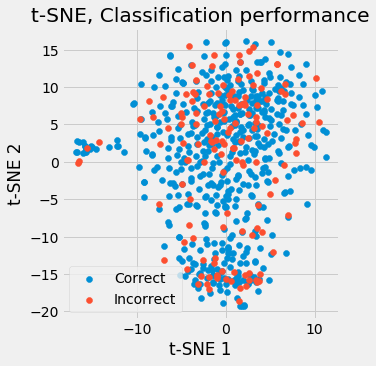

In [176]:
x = StandardScaler().fit_transform(np.log2(X_test+1))
pca = PCA(n_components = 100)
principalComponents = pca.fit_transform(x)
tsne = TSNE(n_components = 2)
X_embedded = tsne.fit_transform(principalComponents)

plt.figure(figsize=(15,5))
plt.subplot(133)
plt.scatter(X_embedded[y_test_pred == y_test,0], X_embedded[y_test_pred == y_test,1])
plt.scatter(X_embedded[y_test_pred != y_test,0], X_embedded[y_test_pred != y_test,1])
plt.legend(['Correct','Incorrect'])
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE, Classification performance')
plt.show()

### *5. Conclusion:*

In summation, this notebook walked through one classification technique — namely, Neural Networks — using murine brain cell data from an aforementioned 2019 Harvard study.  The algorithm's performance was quantified, as will be summarized below (*note that on repeated simulations, accuracy proportions may differ somewhat substantially*).

- Neural networks accuracy: 0.7792998480651658